# Ensemble

## Initialise Ensemble

### Load packages

In [1]:
%matplotlib inline
%load_ext autoreload

import os, sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import datacube
sys.path.append('../../../Scripts')
from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('../../modules')
import gdvspectra, phenolopy, nicher, vegfrax, canopy, ensemble

sys.path.append('../../shared')
import satfetcher, tools

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a dask cluster and ODC

In [2]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

# open up a datacube connection
dc = datacube.Datacube(app='ensemble')

Client Scheduler: tcp://127.0.0.1:37137 Dashboard: /user/lewis/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 125.85 GB


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Study area and data setup

### Set study area, time range, show map

In [3]:
# testing study area extent - yandi and roy hill
#lat_extent, lon_extent = (-22.82901, -22.67901), (118.94980, 119.29979)  # yandi
lat_extent, lon_extent = (-22.63461, -22.33461), (119.88111, 120.18111) # royhill

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

# Generate GDV Likelihood

### Load and prepare DEA ODC satellite data

In [5]:
# provide study area name
study_area = 'royhill'

# select start and end year range
time_range = ('2016', '2020')

# set datacube query parameters
#platform = 'landsat'
#bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']

platform = 'sentinel'
bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3']
min_gooddata = 0.90

# fetch satellite data from dea ard product
ds = satfetcher.load_dea_ard(platform=platform, 
                             bands=bands, 
                             x_extent=lon_extent, 
                             y_extent=lat_extent, 
                             time_range=time_range, 
                             min_gooddata=min_gooddata, 
                             use_dask=True)

# rename dea bands to common standard
ds = satfetcher.conform_dea_ard_band_names(ds=ds, platform=platform)

# take a copy of dataset for cva later
ds_backup = ds.copy(deep=True)

# display dataset
#ds

Loading DEA ODC ARD satellite data.
Finding datasets
    s2a_ard_granule


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,
/home/jovyan/tenement-tools/notebooks/ensemble/../../../Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 197 out of 262 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 197 time steps as a dask array
Satellite imagery fetched successfully.
Conforming DEA ARD satellite band names.
Satellite band names conformed successfully.


### Calculate standardised vege/moist data

In [ ]:
# set wet and dry season month(s). we will use several per season
wet_month, dry_month = [1, 2, 3], [9, 10, 11]

# get subset fo data for wet and dry season months
ds = gdvspectra.subset_months(ds=ds, 
                              month=wet_month + dry_month,
                              inplace=True)

# calculate veg (mavi) and moist (ndmi) indices
ds = tools.calculate_indices(ds=ds, 
                             index=['mavi', 'gvmi'], 
                             custom_name=['veg_idx', 'mst_idx'], 
                             rescale=True, 
                             drop=True)

# perform resampling
ds = gdvspectra.resample_to_wet_dry_medians(ds=ds, 
                                            wet_month=wet_month, 
                                            dry_month=dry_month,
                                            inplace=True)

# we have some calcs to make, persist now
ds = ds.persist()

# drop any years from dataset where wet and dry seasons missing
ds = gdvspectra.drop_incomplete_wet_dry_years(ds)

# todo - remove this compute when bug fixed in ver > 0.18.2
ds = ds.compute()

# fill any empty first, last years using back/forward fill
ds = gdvspectra.fill_empty_wet_dry_edges(ds=ds,
                                         wet_month=wet_month, 
                                         dry_month=dry_month,
                                         inplace=True)

# interpolate all missing pixels using full linear interpolation
ds =  gdvspectra.interp_empty_wet_dry(ds=ds,
                                      wet_month=wet_month, 
                                      dry_month=dry_month,
                                      method='full', 
                                      inplace=True)

# standardise data to invariant targets derived from dry times
ds = gdvspectra.standardise_to_dry_targets(ds=ds, 
                                           dry_month=dry_month, 
                                           q_upper=0.99, 
                                           q_lower=0.05,
                                           inplace=True)

# calculate standardised seaonal similarity (diff between wet, dry per year)
ds_similarity = gdvspectra.calc_seasonal_similarity(ds=ds,
                                                    wet_month=wet_month,
                                                    dry_month=dry_month,
                                                    q_mask=0.9,
                                                    inplace=True)

### Generate likelihood model

In [ ]:
# generate gdv likelihood model using wet, dry, similarity variables
ds_like = gdvspectra.calc_likelihood(ds=ds, 
                                     ds_similarity=ds_similarity,
                                     wet_month=wet_month, 
                                     dry_month=dry_month)

# preview an all-time median of gdv likelihood. red is high likelihood
fig = plt.figure(figsize=(10, 5))
ds_like['like'].median('time').plot(robust=False, cmap='jet')

# create out file
out_like_nc = '../../{0}_{1}_{2}_{3}_like.nc'.format(study_area,
                                                     time_range[0],
                                                     time_range[1],
                                                     platform)

### Generate field occurrence points for thresholding

In [ ]:
# set location of point shapefile with presence/absence column
#shp_path = r'../GDVSDM/data_testing/presence_points/presence_points.shp'
#shp_path = r'../../data/gdvspectra/royhill_2_final_albers.shp'
shp_path = r'../../data/ensemble/royhill/royhill_all_merged.shp'

# read shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset to just x, y, pres/abse column
df_records = tools.subset_records(df_records=df_records, p_a_column='GDV_ACT')

# display dataframe
#df_records

### Threshold likelihood

In [ ]:
# perform thresholding using standard deviation on all-time median likelihood
ds_thresh = gdvspectra.threshold_likelihood(ds=ds_like.median('time', keep_attrs=True),
                                            df=df_records, 
                                            num_stdevs=2.5, 
                                            res_factor=3, 
                                            if_nodata='any')

# preview an all-time median of gdv likelihood thresholded
fig = plt.figure(figsize=(10, 5))
ds_thresh.where(~ds_thresh.isnull(), 0.001)['like'].plot(robust=False, cmap='jet')

### Export GDV likelihood and threshold for later

In [ ]:
# export median likelihood to nc
#tools.export_xr_as_nc(ds=ds_like['like'].median('time'), filename='ds_{}_like.nc'.format(platform))

# export threshold as nc
#tools.export_xr_as_nc(ds_thresh, filename='ds_{}_threshold.nc'.format(platform))

### Calculate trends using Mann-Kendall trend analysis

In [ ]:
# create a mask where gdv highly likely
ds_mask = xr.where(~ds_thresh.isnull(), True, False)

# do mk to find sig. inc/dec trends in high likelihood areas
ds_mk = gdvspectra.perform_mk_original(ds=ds_like.where(ds_mask), 
                                       pvalue=None, 
                                       direction='both')

# show mk trends. blue is increasing, red is decreasing
fig = plt.figure(figsize=(10, 5))
ds_mk['tau'].plot(robust=True, cmap='Spectral')

### Calculate slope using Theil-Sen

In [ ]:
# create a mask where gdv highly likely
ds_mask = xr.where(~ds_thresh.isnull(), True, False)

# do theil sen slopes in high likelihood areas
ds_ts = gdvspectra.perform_theilsen_slope(ds=ds_like.where(ds_mask), 
                                          alpha=0.95)

# show mk trends. blue is increasing, red is decreasing
fig = plt.figure(figsize=(10, 5))
ds_ts['theilsen'].plot(robust=True, cmap='Spectral')

# Generate Phenometrics

### Calculate and pre-process vegetation

In [ ]:
# takes our dask ds and calculates veg index from spectral bands
ds = tools.calculate_indices(ds=ds_backup, 
                             index='mavi', 
                             custom_name='veg_idx', 
                             rescale=False, 
                             drop=True)

# conform edges
ds = phenolopy.conform_edge_dates(ds=ds)

# resample to weekly medians
ds = phenolopy.resample(ds=ds, 
                        interval='1W',
                        inplace=True)

# interpolate missing values
ds = phenolopy.interpolate(ds=ds, 
                           method='full', 
                           inplace=True)

# group into single year of weekly all-time medians
ds = phenolopy.group(ds=ds, 
                     interval='week',
                     inplace=True)

# takes our dask ds and remove outliers from data using median method
ds = phenolopy.remove_outliers(ds=ds, 
                               method='median', 
                               user_factor=2, 
                               z_pval=0.05)

# take dataset and resample data to weekly medians (1WS)
ds = phenolopy.resample(ds=ds, 
                        interval='1W',
                        inplace=True)

# remove any years outside of dominant year
ds = phenolopy.remove_overshoot_times(ds=ds, max_times=3)

# use savitsky-golay filter to smooth across time dimension
ds = phenolopy.smooth(ds=ds, 
                      method='savitsky', 
                      window_length=3, 
                      polyorder=1, 
                      sigma=1)

### Calculate phenometrics

In [ ]:
# compute into memory
ds = ds.compute()

# set desired metrics
#metrics = ['sos', 'eos', 'lios', 'sios', 'liot', 'siot']

# calc phenometrics via phenolopy!
ds = phenolopy.calc_phenometrics(ds=ds,
                                 peak_metric='pos', 
                                 base_metric='vos', 
                                 method='seasonal_amplitude', 
                                 factor=0.2, 
                                 thresh_sides='one_sided', 
                                 abs_value=0.1)

### Display phenometric

In [ ]:
# set the metric to display
metric_name = 'liot_values'
fig = plt.figure(figsize=(9, 7), dpi=85)
ds[metric_name].plot(robust=True, cmap='terrain_r')

### Generate field occurrence points for thresholding

In [ ]:
# set location of point shapefile with presence/absence column
#shp_path = r'../GDVSDM/data_testing/presence_points/presence_points.shp'
#shp_path = r'../../data/gdvspectra/royhill_2_final_albers.shp'
shp_path = r'../../data/ensemble/royhill/royhill_all_merged.shp'

# read shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset to just x, y, pres/abse column
df_records = tools.subset_records(df_records=df_records, p_a_column='GDV_ACT')

# display dataframe
#df_records

### Check AUC of metrics

In [ ]:
# prepare metric for auc
metric = 'lios_values'
da = ds[metric].rename({'variable': 'time'}).to_dataset(promote_attrs=True)
da = da.rename({metric: 'like'})

# threshold to get auc
gdvspectra.threshold_likelihood(ds=da,
                                df=df_records, 
                                num_stdevs=2.5, 
                                res_factor=3, 
                                if_nodata='any')

In [ ]:
# export to nc
tools.export_xr_as_nc(ds=ds, filename='ds_{}_phenometrics.nc'.format(platform))

# Generate Species Distribution Model

### Set up data

In [ ]:
# get continuous rasters. wwe will use lidar
#folder_path = r'../../data/nicher/roy_lidar'
folder_path = r'../../data/nicher/roy_srtm'
rast_cont_list = nicher.get_files_from_path(folder_path)

# drop any undesirable vars 
#rast_cont_list.remove(folder_path + '/' + 'chm_lidar_10m.tif')
#rast_cont_list.remove(folder_path + '/' + 'dem_lidar_10m_fill.tif')
#rast_cont_list.remove(folder_path + '/' + 'dem_lidar_10m.tif')
#rast_cont_list.remove(folder_path + '/' + 'dem_lidar_10m_tri.tif')
rast_cont_list.remove(folder_path + '/' + 'dem_srtm_30m.tif')
rast_cont_list.remove(folder_path + '/' + 'dem_srtm_30m_fill.tif')
rast_cont_list.remove(folder_path + '/' + 'dem_srtm_30m_tri.tif')

# load rasters as individual dataset variables
ds_sdm = satfetcher.load_local_rasters(rast_path_list=rast_cont_list, 
                                       use_dask=True, 
                                       conform_nodata_to=-999)

# compute dask - we need to make calculations
ds_sdm = ds_sdm.compute()

# set path to shapefile
shp_path = r'../../data/nicher/presence_points/presence_points.shp'

# extract point x and y from shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset columns
df_presence = tools.subset_records(df_records=df_records, 
                                   p_a_column=None)

# drop presence column
df_presence = df_presence.drop('actual', axis='columns')

# generate absences using dataset pixels and occurrence coords
df_absence = nicher.generate_absences(ds=ds_sdm, 
                                      occur_shp_path=shp_path,
                                      buff_m=250, 
                                      res_factor=3)

# extract values for presence points
df_presence_data = tools.extract_xr_values(ds=ds_sdm, 
                                           coords=df_presence, 
                                           keep_xy=False, 
                                           res_factor=3)

# do same for absence points
df_absence_data = tools.extract_xr_values(ds=ds_sdm, 
                                          coords=df_absence, 
                                          keep_xy=False, 
                                          res_factor=3)

# remove all presence records containing nodata values
df_presence_data = tools.remove_nodata_records(df_records=df_presence_data,
                                               nodata_value=ds_sdm.nodatavals)

# remove all absence records containing nodata values
df_absence_data = tools.remove_nodata_records(df_records=df_absence_data,
                                               nodata_value=ds_sdm.nodatavals)

# take pres and abse records and combine, add new pres/abse column
df_pres_abse_data = nicher.combine_pres_abse_records(df_presence=df_presence_data, 
                                                     df_absence=df_absence_data)

# generate the matrix. < 0.6 weak collinearity, 0.6-0.8 moderate, >= 0.8 strong
nicher.generate_correlation_matrix(df_records=df_pres_abse_data,
                                   show_fig=True,
                                   show_text=False)

# generate vif scores. 1 = No multicolinearity, 1-5 = moderate, > 5 = high, > 10 = Remove
nicher.generate_vif_scores(df_records=df_pres_abse_data)
plt.show()

# create a random forest estimator using default sklearn parameters
estimator = nicher.create_estimator(estimator_type='rf', 
                                    n_estimators=100)

# generate SDM with 5 replicates and 10% training-testing split
ds_sdm = nicher.generate_sdm(ds=ds_sdm, 
                             df_records=df_pres_abse_data, 
                             estimator=estimator, 
                             rast_cont_list=rast_cont_list, 
                             rast_cate_list=None, 
                             replicates=5, 
                             test_ratio=0.1, 
                             equalise_test_set=False, 
                             calc_accuracy_stats=True)

# show results
fig = plt.figure(figsize=(9, 7), dpi=85)
ds_sdm['sdm_mean'].plot(robust=False, cmap='jet')

### Generate field occurrence points for thresholding

In [ ]:
# set location of point shapefile with presence/absence column
#shp_path = r'../GDVSDM/data_testing/presence_points/presence_points.shp'
#shp_path = r'../../data/gdvspectra/royhill_2_final_albers.shp'
shp_path = r'../../data/ensemble/royhill/royhill_all_merged.shp'

# read shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset to just x, y, pres/abse column
df_records = tools.subset_records(df_records=df_records, p_a_column='GDV_ACT')

# display dataframe
#df_records

### Check AUC of metrics

In [ ]:
# prepare metric for auc
metric = 'sdm_mean'
da = ds_sdm[metric].to_dataset(promote_attrs=True)
da = da.rename({metric: 'like'})
da.attrs.update({'nodatavals': np.nan})

# threshold to get auc
gdvspectra.threshold_likelihood(ds=da,
                                df=df_records, 
                                num_stdevs=2.5, 
                                res_factor=3, 
                                if_nodata='any')

In [ ]:
# export to nc
#tools.export_xr_as_nc(ds=ds_sdm, filename='ds_sdm.nc')

# Generate Veg Frax

### Prepare Landsat satellite image

In [6]:
# calculate veg (mavi) and moist (ndmi) indices
ds_raw = tools.calculate_indices(ds=ds_backup, 
                                 index=['tcg', 'tcb', 'tcw'], 
                                 custom_name=None, 
                                 rescale=False, 
                                 drop=True)

# load into memory now - we have values to modify!
ds_raw = ds_raw.median('time', keep_attrs=True).compute()

Calculating indices: ['tcg', 'tcb', 'tcw'].
Calculating index: tcg
Calculating index: tcb
Calculating index: tcw
Calculated indices successfully.


### Prepare classified hi-def raster

In [7]:
# set path to high-resolution classified image (e.g. 10m Sentinel 2 or 1m WV)
rast_class = r'../../data/vegfrax/class/Vegetation_Mapping_Mine_20181121_rasterised_albers.tif'
ds_class = satfetcher.load_local_rasters(rast_path_list=[rast_class], 
                                         use_dask=True, 
                                         conform_nodata_to=-128)

# do basic preparations (dtype, rename, checks)
ds_class = vegfrax.prepare_classified_xr(ds=ds_class)

# subset high to low extent
ds_class = tools.clip_xr_to_xr(ds_a=ds_class, 
                               ds_b=ds_raw)

# set them manually (make sure you include 0 if reclassifying)
#req_class = [1, 3, 13, 14, 0]
req_class = [3, 0]
ds_class = vegfrax.reclassify_xr(ds=ds_class, 
                                 req_class=req_class,
                                 merge_classes=True,
                                 inplace=True)

# get list of all classes...
req_class = vegfrax.get_xr_classes(ds_class)

# load into memory now - we have values to modify!
ds_class = ds_class.compute()

Converting rasters to an xarray dataset.
Converted raster to xarray data array: Vegetation_Mapping_Mine_20181121_rasterised_albers
Rasters converted to dataset successfully.

Preparing classified dataset.
Prepared classified dataset successfully.
Clipping dataset to another.
Clipped dataset successfully.
Reclassifying classes.
Reclassified dataset successfully.
Getting unique classes from dataset.
Detected classes in dataset: 0, 1


### Prepare frequencies

In [12]:
# generate random samples within area overlap between raw and classified rasters
num_samples = 2000
df_samples = vegfrax.generate_strat_random_samples(ds_raw=ds_raw,
                                                   ds_class=ds_class, 
                                                   req_class=req_class,
                                                   num_samples=num_samples)

# extract pixel values from raw, low resolution rasters at each point
df_extract = tools.extract_xr_values(ds=ds_raw, 
                                     coords=df_samples, 
                                     keep_xy=True)

# remove any points containing a nodata value
df_extract_clean = tools.remove_nodata_records(df_extract, 
                                               nodata_value=ds_raw.nodatavals)

# generate focal windows and extract pixels from class raster
df_windows = vegfrax.create_frequency_windows(ds_raw=ds_raw, 
                                              ds_class=ds_class, 
                                              df_records=df_extract_clean)

# transform raw focal window pixel classes and counts to unique classes and frequencies at each point
df_freqs = vegfrax.convert_window_counts_to_freqs(df_windows=df_windows, 
                                                  nodata_value=ds_class.nodatavals)

Generating 2000 stratified randomised sample points.
Generating stratified random points.
Preparing samples for class: 0
Preparing samples for class: 1
Generated stratified random sample points successfully.
Extracting xarray values to x and y coordinates.
Extracted xarray values successfully.
Removing records containing NoData (nan) values.
Removed 0 records containing NoData values successfully.
Creating frequency focal windows from random sample points.
Computing windows into memory, this can take awhile. Please wait.
4000 windows generated successfully.
Generating class frequencies from window pixels.
Checking for empty rows and dropping if exist.
4000 windows transformed to frequencies successfully.


### Perform FCA

Converting dataset to sklearn analysis-ready format.
Converting classes and frequencies into analysis-ready format.
Normalising rows with regards to subset classes and NoData values.
Creating NoData mask.
Data successfully prepared for analysis.
Beginning fractional cover analysis (FCA).
Fitting and predicting model for class: 1
Mean OOB: 0.66. Mean MAE: 0.16. Mean RMSE: 0.29. Mean R-squared: 0.65. Best R-squared: 0.68
Fractional cover analysis (FCA) completed successfully.


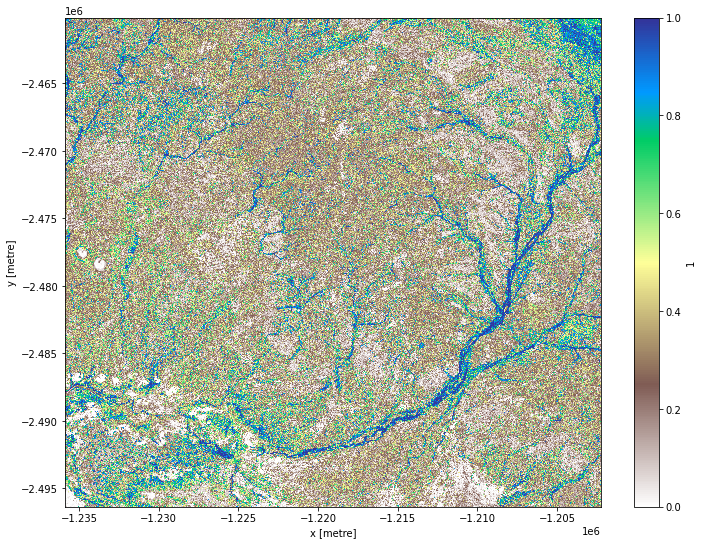

In [13]:
# set desired output classes. keep empty to produce all classes. could put 1, 2 for classes 1 and 2.
override_classes = ['1']

# prepare data for analysis - prepare classes, nulls, normalise frequencies
df_data = vegfrax.prepare_freqs_for_analysis(ds_raw=ds_raw, 
                                             ds_class=ds_class, 
                                             df_freqs=df_freqs, 
                                             override_classes=override_classes)

# perform fca
ds_preds = vegfrax.perform_fca(ds_raw=ds_raw, 
                               ds_class=ds_class, 
                               df_data=df_data, 
                               df_extract_clean=df_extract_clean, 
                               n_estimators=100,
                               n_validations=10)

# create fig
class_label = '1'
fig = plt.figure(figsize=(12, 9))
ds_preds[class_label].plot(robust=False, cmap='terrain_r')

### Generate field occurrence points for thresholding

In [14]:
# set location of point shapefile with presence/absence column
#shp_path = r'../GDVSDM/data_testing/presence_points/presence_points.shp'
#shp_path = r'../../data/gdvspectra/royhill_2_final_albers.shp'
shp_path = r'../../data/ensemble/royhill/royhill_all_merged.shp'

# read shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset to just x, y, pres/abse column
df_records = tools.subset_records(df_records=df_records, p_a_column='GDV_ACT')

# display dataframe
#df_records

Reading records within shapefile.
Rows read from shapefile successfully.
Subsetting records from dataframe.
Subset records successfully.


In [15]:
# prepare metric for auc
ds_preds.attrs = ds.attrs
da = ds_preds.rename({class_label: 'like'})

# threshold to get auc
gdvspectra.threshold_likelihood(ds=da,
                                df=df_records, 
                                num_stdevs=2.5, 
                                res_factor=3, 
                                if_nodata='any')

Thresholding groundwater-dependent vegeation likelihood.
Thresholding dataset via occurrence records and AUC.
Clipping pandas dataframe records to xarray dataset.
Extracted xarray dataset values successfully.
Removing records containing NoData (nan) values.
Removed 0 records containing NoData values successfully.
AUC: 0.825 for whole dataset.
Thresholded dataset successfully.
Thresholded likelihood succuessfully.


<xarray.Dataset>
Dimensions:  (x: 3361, y: 3624)
Coordinates:
  * x        (x) float64 -1.236e+06 -1.236e+06 ... -1.202e+06 -1.202e+06
  * y        (y) float64 -2.46e+06 -2.46e+06 -2.46e+06 ... -2.496e+06 -2.496e+06
Data variables:
    like     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref
    nodatavals:    nan

In [ ]:
ds_preds

In [16]:
# export to nc
tools.export_xr_as_nc(ds=ds_preds, filename='ds_{}_frax.nc'.format(platform))

Exporting xarray as netcdf file.
Exported xarray as netcdf successfully.


## Perform sigmoidals

In [ ]:
# get inputs from arcgis
out_path = r'./'
in_nodataval = np.nan
resample_to = 'lowest'

# get list of layers
in_1 = [r'../../data/ensemble/royhill/like.tif', 0.3, 'Max', None]        # a, bc, d (min, mid, max)
in_2 = [r'../../data/ensemble/royhill/pheno_liot.tif', 5, 'Max', None]    # a, bc, d (min, mid, max)
in_3 = [r'../../data/ensemble/royhill/sdm_lidar.tif', 0.1, 'Max', None]   # a, bc, d (min, mid, max)
in_4 = [r'../../data/ensemble/royhill/chm_lidar_10m.tif', 1, 6, 11]       # a, bc, d (min, mid, max)
in_5 = [r'../../data/ensemble/royhill/vegfrax_class_3_vs_0.tif', None, 'Min', 'Max']  # a, bc, d (min, mid, max)

# combine into a list
in_list = [
    in_1,
    in_2, 
    in_3, 
    in_4, 
    in_5
]   

# load each dataset, append to end of each item list
for item in in_list:
    ds = ensemble.prepare_data(file_list=item[0], 
                               nodataval=in_nodataval)
        
    if ds:
        item.append(ds)
    else:
        item.append(None)

In [ ]:
# loop each input item and apply sigmoidal automatically
in_list = ensemble.apply_auto_sigmoids(items=in_list)

In [ ]:
# export sigmoidals to requested output folder
ensemble.export_sigmoids(items=in_list, out_path=out_path) 

## Perform Ensemble

In [ ]:
# get list of belief layers
b_1_path = r'../../data/ensemble/royhill/like_sigmoid.nc'
b_2_path = r'../../data/ensemble/royhill/pheno_liot_sigmoid.nc'
b_3_path = r'../../data/ensemble/royhill/sdm_lidar_sigmoid.nc'
b_4_path = r'../../data/ensemble/royhill/chm_lidar_10m_sigmoid.nc'

# get lsit of disbelief layers
db_1_path = r'../../data/ensemble/royhill/vegfrax_class_3_vs_0_sigmoid.nc'

# combine belief list
belief_list = [b_2_path, b_3_path, b_4_path]

# combine disbelief list
disbelief_list = [db_1_path]

In [ ]:
# get belief xr datasets
belief_list = ensemble.prepare_data(file_list=belief_list, 
                                    nodataval=np.nan)

# get disbelief xr datasets
disbelief_list = ensemble.prepare_data(file_list=disbelief_list, 
                                       nodataval=np.nan)

In [ ]:
# append dempster type label to belief xr datasets
belief_list = ensemble.append_dempster_attr(ds_list=belief_list, 
                                            dempster_label='belief')

# append dempster type label to disbelief xr datasets
disbelief_list = ensemble.append_dempster_attr(ds_list=disbelief_list, 
                                               dempster_label='disbelief')

In [ ]:
# resample all datasets to lowest resolution
ds_list = ensemble.resample_datasets(ds_list=belief_list + disbelief_list, 
                                     resample_to='lowest', 
                                     resampling='nearest')

In [ ]:
# check if values are 0-1?

In [ ]:
# perform dempster shafer modelling
ds_dempster = ensemble.perform_dempster(ds_list=ds_list)
ds_dempster['belief'].plot(robust=False)